### Exploratory Data Analysis

### Importing the libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from glob import glob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

import spacy
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Mounting google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Reading the data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/feedback-prize-2021/train.csv')
sample_submission_file = pd.read_csv('/content/drive/MyDrive/feedback-prize-2021/sample_submission.csv')
train_essays = glob('/content/drive/MyDrive/feedback-prize-2021/train/*.txt')
test_essays = glob('/content/drive/MyDrive/feedback-prize-2021/test/*.txt')

In [ ]:
train_data[['discourse_id', 'discourse_start', 'discourse_end']] = train_data[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

In [ ]:
train_data.query('id == "AFEC37C2D43F"')


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
144270,AFEC37C2D43F,1617802866874,0,317,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
144271,AFEC37C2D43F,1617802860610,318,515,"Because of this, sometimes, asking just one pe...",Position,Position 1,61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 7...
144272,AFEC37C2D43F,1617802685185,684,692,"mistake,",Claim,Claim 1,120
144273,AFEC37C2D43F,1617802691320,693,710,"misunderstanding,",Claim,Claim 2,121
144274,AFEC37C2D43F,1617802696697,714,724,misdeed.,Claim,Claim 3,123
144275,AFEC37C2D43F,1617802785480,725,1360,While mistakes and misunderstanding might have...,Evidence,Evidence 1,124 125 126 127 128 129 130 131 132 133 134 13...
144276,AFEC37C2D43F,1617802780393,1361,1471,"The more similar iterations people give you, t...",Claim,Claim 4,234 235 236 237 238 239 240 241 242 243 244 24...
144277,AFEC37C2D43F,1617802727496,1472,1881,Misunderstandings are harder to avoid because ...,Evidence,Evidence 2,252 253 254 255 256 257 258 259 260 261 262 26...
144278,AFEC37C2D43F,1617802715474,1882,2019,The best thing to do in a situation like that ...,Claim,Claim 5,326 327 328 329 330 331 332 333 334 335 336 33...
144279,AFEC37C2D43F,1617802754835,2029,2123,misdeeds are when the advice-giver is purpose...,Claim,Claim 6,354 355 356 357 358 359 360 361 362 363 364 36...


* The prediction string indicates the index of words in the essay.

### Distribution of discourse_type
* Claim and Evidence are more frequently occurred in all the essays.
* Counterclaim and Rebuttal are relatively infrequent in their occurrence.

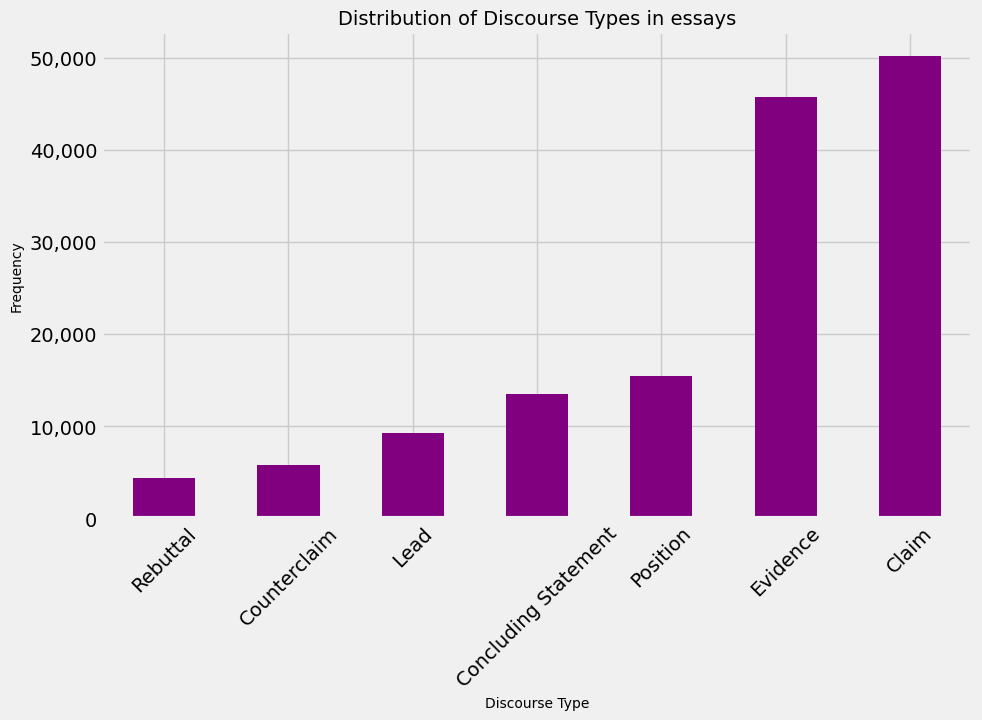

In [ ]:
plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(10,6))
ax = train_data.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="bar", color='purple')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.set_title("Distribution of Discourse Types in essays", fontsize=14)
ax.set_xlabel("Discourse Type",fontsize = 10)
ax.set_ylabel("Frequency", fontsize = 10)


plt.show()

* Evidence1, Position1, and Claim1 are consistently present in most essays.
* A significant majority of students include at least one Concluding Statement.
* Surprisingly, approximately 40% of the essays lack a Lead, whereas Lead 1 appears in nearly 60% of the essays.


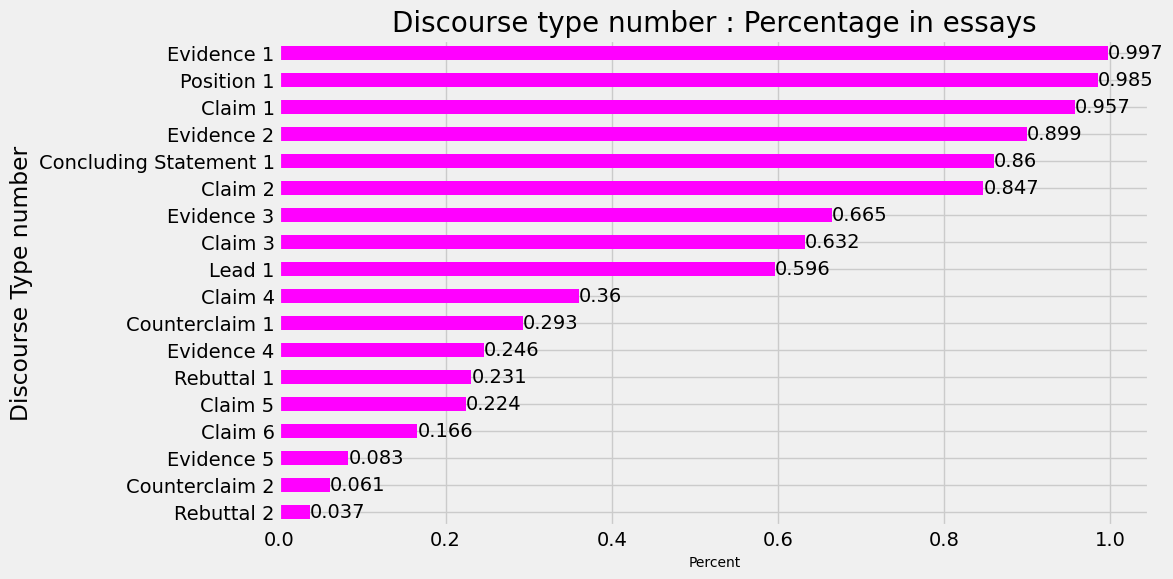

In [ ]:
plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(10,6))
avg_percentage = train_data['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
avg_percentage['percentage'] = round((avg_percentage['count'] / train_data.id.nunique()),3)
avg_percentage = avg_percentage.set_index('discourse_type_num')
ax = avg_percentage.query('percentage > 0.03')['percentage'].plot(kind="barh",color= 'magenta')
ax.set_title("Discourse type number : Percentage in essays", fontsize=20)
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent", fontsize = 10)
ax.set_ylabel("Discourse Type number")
plt.show()

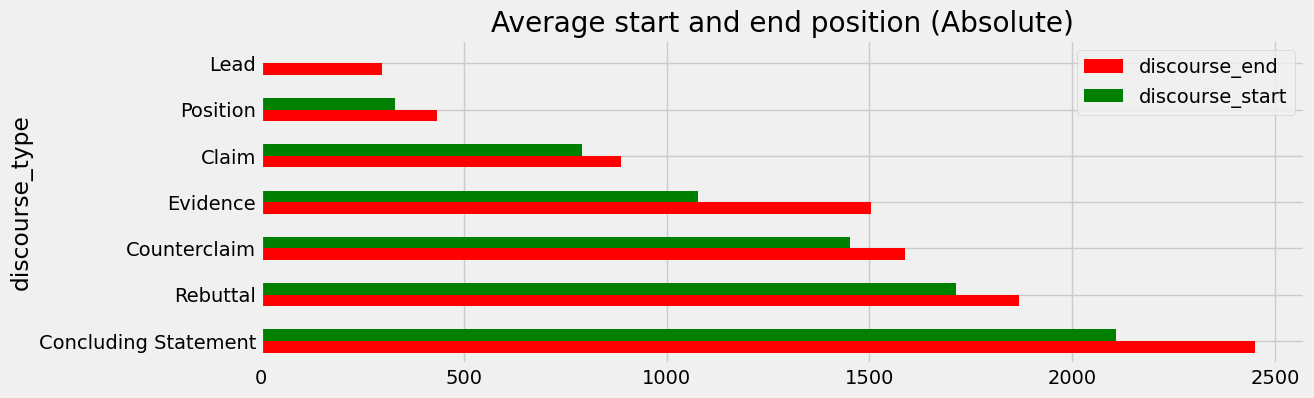

In [ ]:
#plot illustrates the average positions of the discourse start and end.
df_temp = train_data.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(by = 'discourse_start', ascending = False)
df_temp.plot(x='discourse_type',
        kind='barh',
        stacked=False,
        title='Average start and end position (Absolute)',
        figsize=(12,4),
        color=['red', 'green'])
plt.show()

* When a Lead is present, it is typically identified as the first discourse in the essay.

###  gaps in essays!

In [ ]:
lenght_dictionary = {}
wd_dictionary = {}
for t in tqdm(train_essays):
    with open(t, "r") as train_essays:
        id_temp = t.split("/")[-1].replace(".txt", "")
        data = train_essays.read()
        length_temp = len(data.strip())
        temp_word = len(data.split())
        lenght_dictionary[id_temp] = length_temp
        wd_dictionary[id_temp] = temp_word
train_data["essay_length"] = train_data["id"].map(lenght_dictionary)
train_data["essay_words"] = train_data["id"].map(wd_dictionary)


  0%|          | 0/15664 [00:00<?, ?it/s]

In [ ]:
train_data['Gap_length'] = np.nan

train_data.loc[0, 'Gap_length'] = 7

for i in tqdm(range(1, len(train_data))):
    if ((train_data.loc[i, "id"] == train_data.loc[i-1, "id"])\
        and (train_data.loc[i, "discourse_start"] - train_data.loc[i-1, "discourse_end"] > 1)):
        train_data.loc[i, 'Gap_length'] = train_data.loc[i, "discourse_start"] - train_data.loc[i-1, "discourse_end"] - 2

    elif ((train_data.loc[i, "id"] != train_data.loc[i-1, "id"])\
        and (train_data.loc[i, "discourse_start"] != 0)):
        train_data.loc[i, 'Gap_length'] = train_data.loc[i, "discourse_start"] -1


last_words = train_data.drop_duplicates(subset="id", keep='last')
last_words['Gap_end_length'] = np.where((last_words.discourse_end < last_words.essay_length),\
                                       (last_words.essay_length - last_words.discourse_end),\
                                       np.nan)

columns_to_add = ['id', 'discourse_id', 'Gap_end_length']
train_data = train_data.merge(last_words[columns_to_add], on = ["id", "discourse_id"], how = "left")

  0%|          | 0/144292 [00:00<?, ?it/s]

In [ ]:
features = ['id', 'discourse_start', 'discourse_end', 'discourse_type', 'essay_length', 'Gap_length', 'Gap_end_length']

In [ ]:
print(f"There are {len(train_data)} discourse texts, But {len(train_data.query('Gap_length.notna()', engine='python'))+ len(train_data.query('Gap_end_length.notna()', engine='python'))} pieces of text are not classified.")

There are 144293 discourse texts, But 32162 pieces of text are not classified.


We have huge gaps in some essays.

In [ ]:
train_data.sort_values(by = "Gap_length", ascending = False)[features].head()

,id,discourse_start,discourse_end,discourse_type,essay_length,Gap_length,Gap_end_length
12921,7330313ED3F0,3377,3846,Concluding Statement,3829,2245.0,NaN
20537,7DF12B42AB72,3596,4231,Rebuttal,6012,2232.0,NaN
11685,4DF55925F544,2845,3013,Evidence,3846,2137.0,NaN
88336,43CBE96B374E,3115,3371,Concluding Statement,3689,1726.0,318.0
103994,134A4DA02013,2049,2176,Claim,3301,1680.0,NaN


In [ ]:
train_data.sort_values(by = "Gap_end_length", ascending = False)[features].head()

,id,discourse_start,discourse_end,discourse_type,essay_length,Gap_length,Gap_end_length
28134,C278EDC82048,524,667,Evidence,8015,NaN,7348.0
8567,129497C3E0FC,386,443,Position,3616,103.0,3173.0
1204,F92664C55FBB,541,628,Evidence,3767,NaN,3139.0
91438,F5EE08CB44B9,124,353,Claim,3022,NaN,2669.0
6110,8E3B8CFD4256,1111,1295,Claim,3821,NaN,2526.0


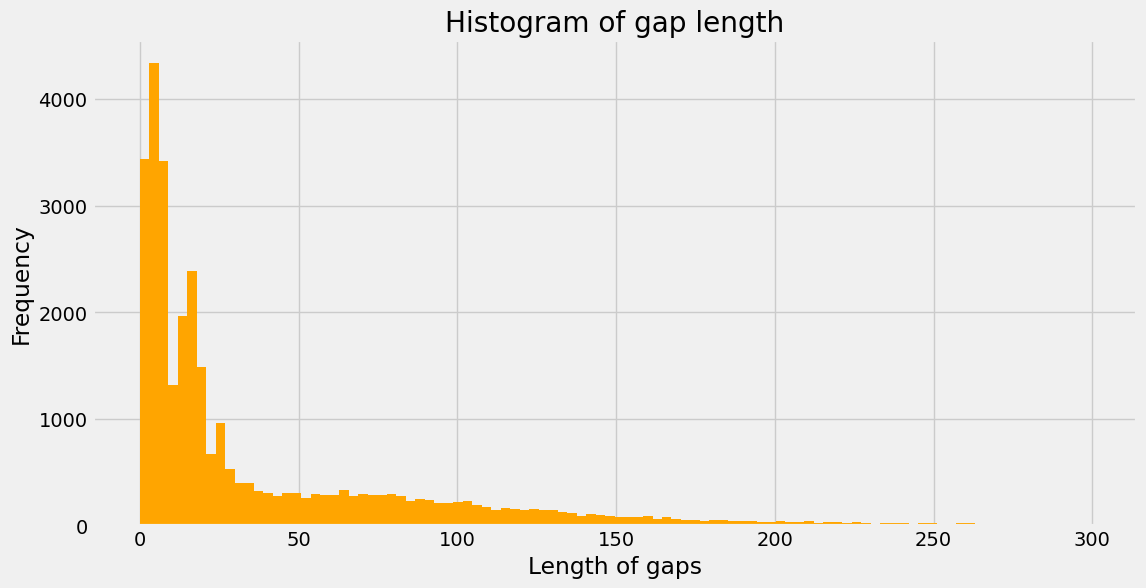

In [ ]:
plt.style.use('seaborn-colorblind')
gaps = (train_data.Gap_length[~train_data.Gap_length.isna()]).append((train_data.Gap_end_length[~train_data.Gap_end_length.isna()]), ignore_index= True)
gaps = gaps[gaps<300]
fig = plt.figure(figsize=(12,6))
gaps.plot.hist(bins=100,color='orange')
plt.title("Histogram of gap length")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps")
plt.show()


* Some essays have a significant portion of the text not classified as any discourse type, with approximately 90% remaining unclassified.
* One specific case had a Gap_end_length of 7348.

In [ ]:
gaps_combined = train_data.groupby('id').agg({'essay_length': 'first',\
                                               'Gap_length': 'sum',\
                                               'Gap_end_length': 'sum'})
gaps_combined['%_not_classified'] = round(((gaps_combined.Gap_length + gaps_combined.Gap_end_length)/gaps_combined.essay_length),2)

gaps_combined.sort_values(by = '%_not_classified', ascending = False).head()

,essay_length,Gap_length,Gap_end_length,%_not_classified
id,,,,
C278EDC82048,8015,13.0,7348.0,0.92
129497C3E0FC,3616,130.0,3173.0,0.91
F5EE08CB44B9,3022,62.0,2669.0,0.90
B7C17E1993BA,3569,1110.0,2060.0,0.89
F45B396E0A01,1865,1657.0,0.0,0.89


### printing essay

In [ ]:
def add_gaps(essay):
    new_cols = ['discourse_start', 'discourse_end', 'discourse_type', 'Gap_length', 'Gap_end_length']
    essay_text_data = train_data.query('id == @essay')[new_cols].reset_index(drop = True)

    add_row = len(essay_text_data)

    for i in range(1, len(essay_text_data)):
        if essay_text_data.loc[i,"Gap_length"] >0:
            if i == 0:
                start = 0
                end = essay_text_data.loc[0, 'discourse_start'] -1
                type_discourse = "Gap"
                gap_end = np.nan
                gap = np.nan
                essay_text_data.loc[add_row] = [start, end, type_discourse, gap, gap_end]
                add_row += 1
            else:
                start = essay_text_data.loc[i-1, "discourse_end"] + 1
                end = essay_text_data.loc[i, 'discourse_start'] -1
                type_discourse = "Gap"
                gap_end = np.nan
                gap = np.nan
                essay_text_data.loc[add_row] = [start, end, type_discourse, gap, gap_end]
                add_row += 1

    essay_text_data = essay_text_data.sort_values(by = "discourse_start").reset_index(drop=True)

    if essay_text_data.loc[(len(essay_text_data)-1),'Gap_end_length'] > 0:
        start = essay_text_data.loc[(len(essay_text_data)-1), "discourse_end"] + 1
        end = start + essay_text_data.loc[(len(essay_text_data)-1), 'Gap_end_length']
        type_discourse = "Gap"
        gap_end = np.nan
        gap = np.nan
        essay_text_data.loc[add_row] = [start, end, type_discourse, gap, gap_end]

    return(essay_text_data)

In [ ]:
add_gaps("129497C3E0FC")

,discourse_start,discourse_end,discourse_type,Gap_length,Gap_end_length
0,0,57.0,Lead,NaN,NaN
1,58,111.0,Claim,NaN,NaN
2,112,120.0,Gap,NaN,NaN
3,121,137.0,Claim,8.0,NaN
4,138,157.0,Gap,NaN,NaN
5,158,281.0,Counterclaim,19.0,NaN
6,282,385.0,Gap,NaN,NaN
7,386,443.0,Position,103.0,3173.0
8,444,3617.0,Gap,NaN,NaN


In [ ]:
def print_essay(essay):
    essay_text_data = add_gaps(essay)
    esaay_doc = "/content/drive/MyDrive/feedback-prize-2021/train/" + essay + ".txt"

    ents = []
    for i, row in essay_text_data.iterrows():
        ents.append({
                        'start': int(row['discourse_start']),
                         'end': int(row['discourse_end']),
                         'label': row['discourse_type']
                    })

    with open(esaay_doc, 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
    }

    colors = {'Lead': '#D7BBF5','Position': '#0B666A','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
    opts = {"ents": essay_text_data.discourse_type.unique().tolist(), "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=opts, manual=True, jupyter=True);

In [ ]:
print_essay("129497C3E0FC")